# Scattering Matrix

First, test if the scattering matrix calculation works without calculatng the viewing matrix. In order to do this, we need to load up some cross section data to initialize `Gas`. Then, we need to load some neutral densities, temperature and an ionosphere to create an `Atmosphere`.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
import numpy as np
import scipy.integrate, scipy.interpolate
import pyauric, mcrt

In [2]:
from mcrt.test import TestAtmosphere
atmosphere = TestAtmosphere()

In [3]:
Mm = atmosphere.multiple_scatter_matrix( 2, view_height=False )

In [5]:
thin_lines = ! grep "O.*83[234] A.*initial.*" inputs/dayglo.ver 
thick_lines = ! grep "83[234].*final" inputs/dayglo.ver

In [6]:
auric = pyauric.AURICManager('./inputs')
feautrier = auric.retrieve( "dayglo.ver", features=thick_lines )
sourcef = auric.retrieve( "dayglo.ver", features=thin_lines )
S = scipy.interpolate.interp1d(sourcef['ALT'][::-1]*1e5, sourcef['O+hv 834 A (initial)'][::-1])
z = sourcef['ALT']
S0 = np.hstack( [ S(atmosphere.z) / 2 ]*2 )
cdf = -scipy.integrate.cumtrapz(sourcef['O+hv 834 A (initial)'], sourcef['ALT'], initial=0) 
cdf = 1 - cdf / np.max(cdf)
dcdf = cdf[1:]-cdf[:-1]
dx = sourcef['ALT'][:-1] - sourcef['ALT'][1:]
pdf = np.zeros_like(cdf)
pdf[1:] = -dcdf/dx
#plt.plot(sourcef['ALT'],cdf, sourcef['ALT'], pdf)

#S0 = np.max(sourcef['O+hv 834 A (initial)'])/np.max(pdf) * pdf
#S0_interp = scipy.interpolate.interp1d(sourcef['ALT'][::-1], S0[::-1], bounds_error=False, fill_value = 0)
#y = S0_interp(atmosphere.z*1e-5)
#S0 = np.hstack( [ y / 2 ] * 2 )
SF = np.dot( S0, Mm )
# print SF
SF = SF.reshape( (2, len(SF)/2) )
# print SF
SF = np.sum(SF, axis=0)
# print SF

## Next Steps

* Weight elements non-uniformly in optical depth
    * At higher altitudes, the initial source does change rapidly
    * Increasing altitude reolution to 1 km has no effect
* Add higher angular resolution
    * Not sure how this would help -- maybe having slightly shorter paths will increase transport
* Closer look at CFR -- I'll try this first

In [11]:
atmosphere.calculate_view_depth(600)
[atmosphere.R( l, e, 0 ) for l in atmosphere.transient for e in atmosphere.ergodic];

In [12]:
atmosphere.R((1,1),1,1)

0.0

In [13]:
w=2
Q = np.fromiter( (np.sum(atmosphere.lineshape[w] * atmosphere.Q(k,l,w)) 
                  for k in atmosphere.transient for l in atmosphere.transient  ), 
                dtype=float ) 
n = len(atmosphere.transient)
Q = Q.reshape((n,n))


R = np.fromiter( (atmosphere.R( l, e, w ) 
                  for l in atmosphere.transient for e in atmosphere.ergodic  ),
                dtype=float )
r = len(atmosphere.ergodic)
R = R.reshape( ( n, r ) )

In [14]:
I = np.eye( Q.shape[0] )
np.isclose(np.dot( Mm, (I-Q) ), I ).all()

False

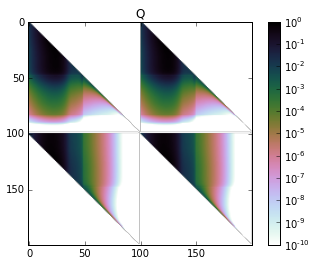

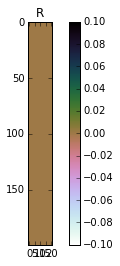

In [15]:
plt.figure()
plt.title("Q")
plt.imshow(Q, cmap=cm.cubehelix_r, norm=LogNorm(vmin=1e-10, vmax=1))
plt.colorbar();
plt.figure()
plt.title("R")
plt.imshow(R, cmap=cm.cubehelix_r)
plt.colorbar();

<matplotlib.colorbar.Colorbar instance at 0x108157950>

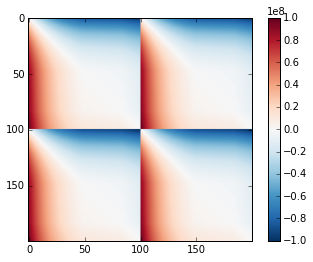

In [16]:
n = np.array( [ s[1] for s in atmosphere.transient ] )
i = np.array( [ s[0] for s in atmosphere.transient ] )
plt.imshow(np.fromiter((z_target - z_source for z_source in atmosphere.z[n]\
 for z_target in atmosphere.z[n]), dtype=np.float ).reshape((len(n),len(n))), cmap=cm.RdBu_r)
plt.colorbar()

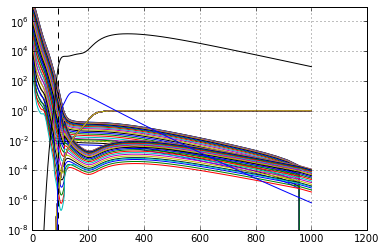

In [17]:
x = atmosphere.z*1e-5
plt.plot( x, atmosphere.tau[0] )
plt.plot( x, atmosphere.dtau[0] )
plt.plot( x, atmosphere.albedo[0] )
plt.plot( x, atmosphere.oplus )
plt.plot( z, S(z*1e5) )
plt.axvline(90, color='k', ls='--')
plt.grid()
plt.ylim(1e-8,1e7)
plt.yscale('log')

In [ ]:
# plt.plot(atmosphere.z, msis_n["O"], label="O", ls='--', lw=2)
# plt.plot(atmosphere.z, msis_n["N2"], label="N2", ls='--', lw=2)
# plt.plot(atmosphere.z, msis_n["O2"], label="O2", ls='--', lw=2)
# plt.plot(atmosphere.z, atmosphere.oplus, label="O+", lw=2)
# edp = auric.retrieve("ionos.dat", features=['[e-]'])
# plt.plot(edp["ALT"]*1e5,edp["[e-]"], label="e-", alpha=0.5, lw=2)
# plt.plot()
# plt.legend(); plt.grid(b=True, which='both')
# plt.ylim(1e3,1e6)
# plt.yscale('log')

# Do the viewing angles work?

One way to find out. (The weights are incorrect, so it will probably explode or something.)

In [ ]:
X = atmosphere.multiple_scatter_matrix( 2, view_height=600 )
X.shape

In [ ]:
pdf_interp = scipy.interpolate.interp1d( x=z[::-1]*1e5, y=pdf[::-1], bounds_error=False, fill_value=0 )

PI_0 = np.hstack( [pdf_interp(atmosphere.z) / 2]*2 ) 
out = np.dot( PI_0, X )
#plt.plot(PI_0)
plt.plot( viewing_angles * 180 / np.pi, out )
#plt.yscale('log')

In [ ]:
!say done

In [ ]:
plt.plot(z, pdf)
plt.plot(atmosphere.z*1e-5, PI_0[:atmosphere.N_layers])
plt.plot(atmosphere.z*1e-5, PI_0[atmosphere.N_layers:])
plt.yscale('log')

In [ ]:
mu_j = atmosphere.mu[0]
mu_e = -np.cos(viewing_angles[0])
tau = 1.0001
tau_prime = atmosphere.tau[2]
albedo = atmosphere.albedo[2]


# Sanity Check

The sum of each row of Q should be no more than one, since every photon comes from somewhere, but it may be less, because the absorbed photons are not accounted for by any state

In [ ]:
plt.plot(np.sum(Q ,axis=0))#+np.sum(R,axis=1) )
plt.yscale('log')
plt.ylim(1e-4,100)

In [ ]:
print np.arange(10).reshape((2,5))
print np.fromiter( (a*b for b in (+1, -1) for a in xrange(5) ), dtype=np.int32).reshape((2,5))

In [ ]:
kB = 1.3806488e-23 # J / K

# speed of light
c = 2.99792458e8 # m / s

def sdu( m, T ):
    """Doppler unit for mass `m` and temperature `T`.
    The standard deviation for a doppler-broadened line centered at 'nu' is `sdu( m, T ) * nu` """
    return np.sqrt( kB * T / m / c**2 )


In [ ]:
sdu( 16 * amu, 700 )

In [ ]:
a = np.arange(9).reshape(1,9)


In [ ]:
atmosphere.Q((0,5),(0,5),1).shape

In [ ]:
scipy.special.erf(1e-6)

In [ ]:
scipy.special.erf( mcrt.freq_param() )

In [ ]:
atmosphere.lineshape[0][5,:]

In [ ]:
Hbig=60
Nbig=1.5e5
hbig=330
def big_chapman(z):
    return (Nbig)*np.exp((1-(z-hbig)/Hbig-np.exp(-(z-hbig)/Hbig))/2)
Hlit=55
Nlit=7e3
hlit=120
def little_chapman(z): 
    return (Nlit)*np.exp((1-(z-hlit)/Hlit-np.exp(-(z-hlit)/Hlit))/2)
opd = big_chapman(msis_n['ALT']) + little_chapman(msis_n['ALT'])
plt.plot( msis_n['ALT'], opd )

In [ ]:
plt.plot(altitudes);plt.yscale('log');plt.grid(which='both')

In [ ]:
a = np.arange(6).reshape((2,3))
for x in enumerate(a):
    print x

In [ ]:
len(atmosphere.transient), len(atmosphere.ergodic), len(viewing_angles)

In [ ]:
arr = np.reshape(np.random.random(25),(5,5))
vec = np.reshape(np.random.random(15),(5,3))
arr, vec

In [ ]:
np.linalg.solve(arr,vec)

In [ ]:
plt.imshow(X, cmap=cm.gray_r)

In [ ]:
np.reshape(np.arange(25),(5,5))

In [ ]:
R

In [ ]:
np.asarray(np.arange(10)), np.asarray(0)